In [1]:
# 📦 Gerekli kütüphanelerin yüklenmesi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
import gradio as gr

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)

nltk.download('stopwords')
turkce_stopwords = set(stopwords.words('turkish'))


C:\Users\yrnck\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yrnck\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# 🧹 Metin temizleme fonksiyonu
def temizle(yorum):
    yorum = str(yorum).lower()
    yorum = re.sub(r"http\S+", "", yorum)
    yorum = re.sub(r"[^a-zçğıöşü0-9\s]", "", yorum)
    yorum = re.sub(r"\s+", " ", yorum).strip()
    yorum = " ".join([w for w in yorum.split() if w not in turkce_stopwords])
    return yorum


In [3]:
# 🗃️ Veri setini yükleme ve temizleme işlemleri
df = pd.read_csv("eticaret-urun-yorumlari.csv", sep=";")
df.columns = ["Metin", "Durum"]

# Yalnızca 0 ve 1 sınıflarını al
df = df[df["Durum"].isin([0, 1])]

# Yorumları temizle
df["temiz_yorum"] = df["Metin"].apply(temizle)

# Çok kısa yorumları çıkar
df = df[df["temiz_yorum"].str.len() > 5]

# Shuffle (karıştırma)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


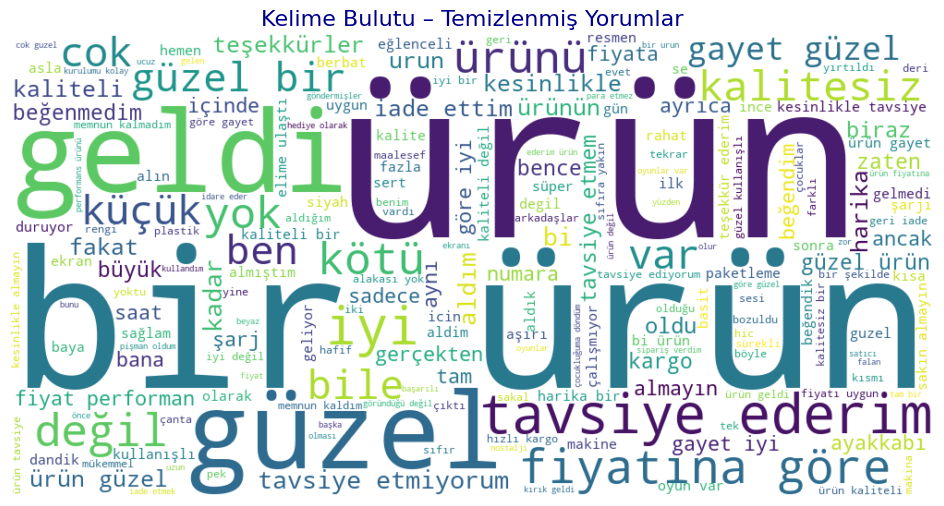

In [4]:
# ☁️ Kelime bulutu ile genel görünüm
wc = WordCloud(
    width=1000,
    height=500,
    background_color='white',
    colormap='viridis',
    max_words=200
).generate(" ".join(df["temiz_yorum"]))

plt.figure(figsize=(14, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Kelime Bulutu – Temizlenmiş Yorumlar", fontsize=16, color="darkblue")
plt.show()


In [5]:
# 📊 Eğitim ve test verisinin ayrılması (60% eğitim, 40% test)
X_train, X_test, y_train, y_test = train_test_split(
    df["temiz_yorum"],
    df["Durum"],
    test_size=0.4,
    random_state=42,
    stratify=df["Durum"]
)


In [6]:
# 🔄 Geliştirilmiş TF-IDF Vektörleştirme (Logistic Regression için)
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),   # unigram ve bigram
    min_df=2,             # en az 2 belgede geçen kelimeler
    max_df=0.90,          # %90'dan fazla belgede geçen kelimeleri dışla
    max_features=5000     # en anlamlı 5000 kelime
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


In [7]:
# 🧠 Logistic Regression modeli (class_weight ile dengelenmiş)
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
model.fit(X_train_vec, y_train)
y_pred = model.predict(X_test_vec)


In [8]:
# 🧠 MultinomialNB modeli için sadeleştirilmiş TF-IDF ve eğitim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# Daha sade TF-IDF
vectorizer_nb = TfidfVectorizer(
    ngram_range=(1, 1),   # sadece tek kelimeler
    min_df=3,             # en az 3 belgede geçen kelimeler
    max_df=0.95,          # %95'ten fazla geçenleri çıkar
    max_features=5000     # sadece en anlamlı 5000 kelime
)

X_train_vec_nb = vectorizer_nb.fit_transform(X_train)
X_test_vec_nb = vectorizer_nb.transform(X_test)

# Modeli eğit
model_nb = MultinomialNB(alpha=0.5)  # smoothing değeri (daha dengeli sonuçlar verir)
model_nb.fit(X_train_vec_nb, y_train)


,alpha,0.5
,force_alpha,True
,fit_prior,True
,class_prior,None


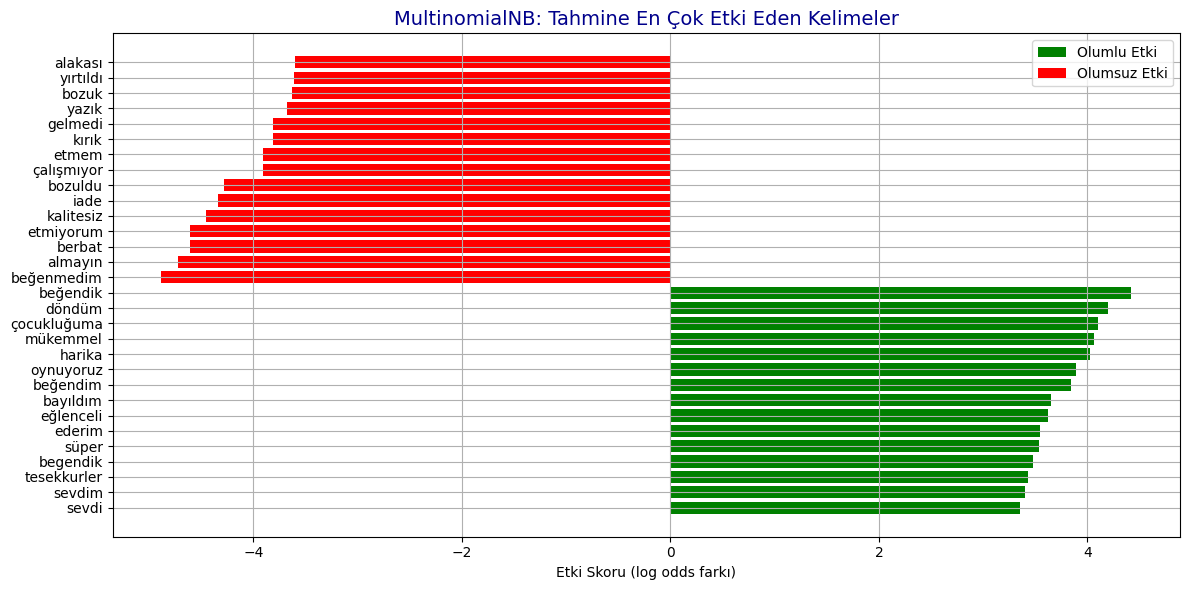

In [9]:
# 🔍 En Etkili Kelimeleri Görselleştir – MultinomialNB (Log odds farkı)
import numpy as np
import matplotlib.pyplot as plt

log_probs = model_nb.feature_log_prob_
importance = log_probs[1] - log_probs[0]  # Olumlu - Olumsuz

# En olumlu ve olumsuz kelimeleri sırala
top_positive_idx = np.argsort(importance)[-15:]
top_negative_idx = np.argsort(importance)[:15]

feature_names = np.array(vectorizer_nb.get_feature_names_out())
top_pos_words = feature_names[top_positive_idx]
top_pos_values = importance[top_positive_idx]
top_neg_words = feature_names[top_negative_idx]
top_neg_values = importance[top_negative_idx]

# Grafik çiz
plt.figure(figsize=(12, 6))
plt.barh(top_pos_words, top_pos_values, color='green', label="Olumlu Etki")
plt.barh(top_neg_words, top_neg_values, color='red', label="Olumsuz Etki")
plt.title("MultinomialNB: Tahmine En Çok Etki Eden Kelimeler", fontsize=14, color="darkblue")
plt.xlabel("Etki Skoru (log odds farkı)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
# 🔁 Test seti üzerinde MultinomialNB tahminleri
y_pred_nb = model_nb.predict(X_test_vec_nb)


C:\Users\yrnck\AppData\Local\Temp\ipykernel_25376\3030098589.py:14: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\yrnck\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


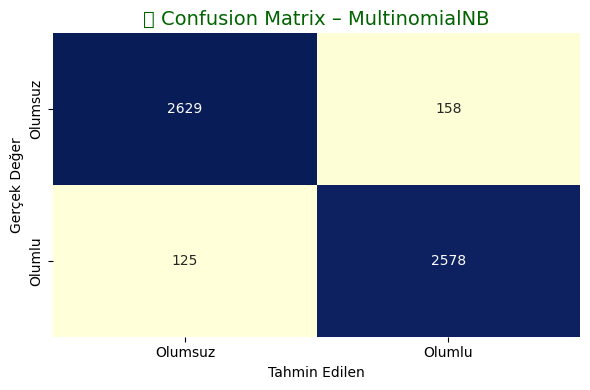

In [11]:
# 📉 Confusion Matrix – Isı haritası şeklinde görselleştirme
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_nb)
etiketler = ["Olumsuz", "Olumlu"]

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=etiketler, yticklabels=etiketler, cbar=False)
plt.title("🎯 Confusion Matrix – MultinomialNB", fontsize=14, color="darkgreen")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Değer")
plt.tight_layout()
plt.show()


C:\Users\yrnck\AppData\Local\Temp\ipykernel_25376\1498538455.py:16: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\yrnck\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


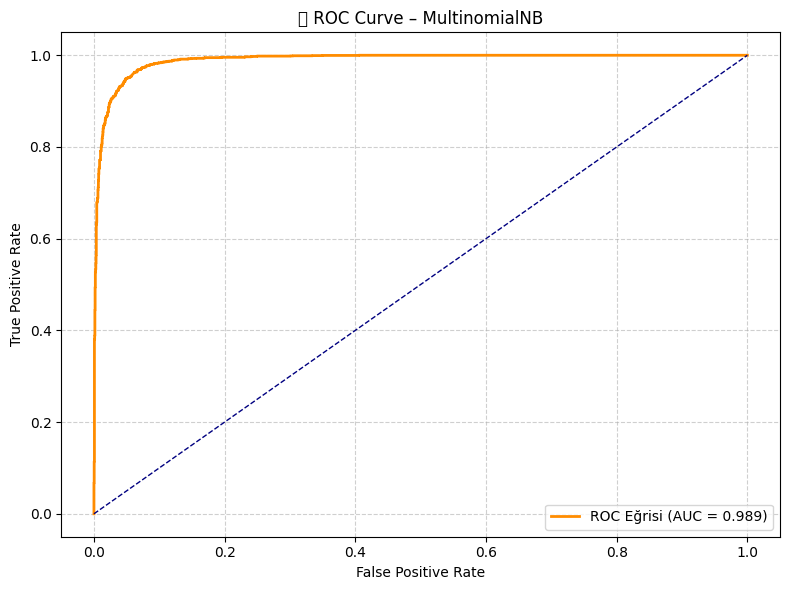

In [12]:
# 🚀 ROC Eğrisi – MultinomialNB modeli için
from sklearn.metrics import roc_curve, auc

y_probs_nb = model_nb.predict_proba(X_test_vec_nb)[:, 1]  # Pozitif sınıf olasılığı
fpr, tpr, _ = roc_curve(y_test, y_probs_nb)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Eğrisi (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("🚀 ROC Curve – MultinomialNB")
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [13]:
# 🧠 MultinomialNB modeli eğitimi
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

vectorizer_nb = TfidfVectorizer(ngram_range=(1, 2), min_df=2, max_df=0.9, max_features=5000)
X_train_vec_nb = vectorizer_nb.fit_transform(X_train)
X_test_vec_nb = vectorizer_nb.transform(X_test)

model_nb = MultinomialNB(alpha=0.5)
model_nb.fit(X_train_vec_nb, y_train)


,alpha,0.5
,force_alpha,True
,fit_prior,True
,class_prior,None


In [14]:
# 🧪 MultinomialNB Model Performansı (Test Seti Üzerinde)
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

y_pred_nb = model_nb.predict(X_test_vec_nb)

print("🎯 Doğruluk:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb, target_names=["Olumsuz", "Olumlu"]))

cm_nb = confusion_matrix(y_test, y_pred_nb)


🎯 Doğruluk: 0.9522768670309654
              precision    recall  f1-score   support

     Olumsuz       0.96      0.94      0.95      2787
      Olumlu       0.94      0.96      0.95      2703

    accuracy                           0.95      5490
   macro avg       0.95      0.95      0.95      5490
weighted avg       0.95      0.95      0.95      5490



C:\Users\yrnck\AppData\Local\Temp\ipykernel_25376\1129828557.py:8: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\yrnck\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


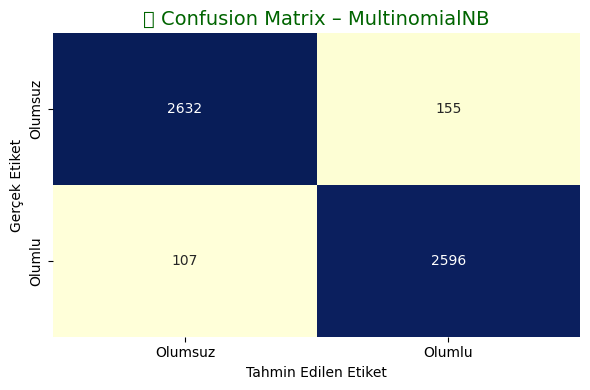

In [15]:
# 🧩 Confusion Matrix Görselleştirme (MultinomialNB)
plt.figure(figsize=(6, 4))
etiketler = ["Olumsuz", "Olumlu"]
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="YlGnBu", xticklabels=etiketler, yticklabels=etiketler, cbar=False)
plt.title("🎯 Confusion Matrix – MultinomialNB", fontsize=14, color="darkgreen")
plt.xlabel("Tahmin Edilen Etiket")
plt.ylabel("Gerçek Etiket")
plt.tight_layout()
plt.show()


In [16]:
# 🧪 Cross Validation (5-fold) ile doğruluk skorları – MultinomialNB
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model_nb, X_train_vec_nb, y_train, cv=5)
print("CV Doğruluk Skorları:", cv_scores)
print("Ortalama CV Skoru:", np.mean(cv_scores))


CV Doğruluk Skorları: [0.94778385 0.96114147 0.95324833 0.93928355 0.94775213]
Ortalama CV Skoru: 0.9498418642533537


C:\Users\yrnck\AppData\Local\Temp\ipykernel_25376\1456068301.py:26: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\yrnck\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


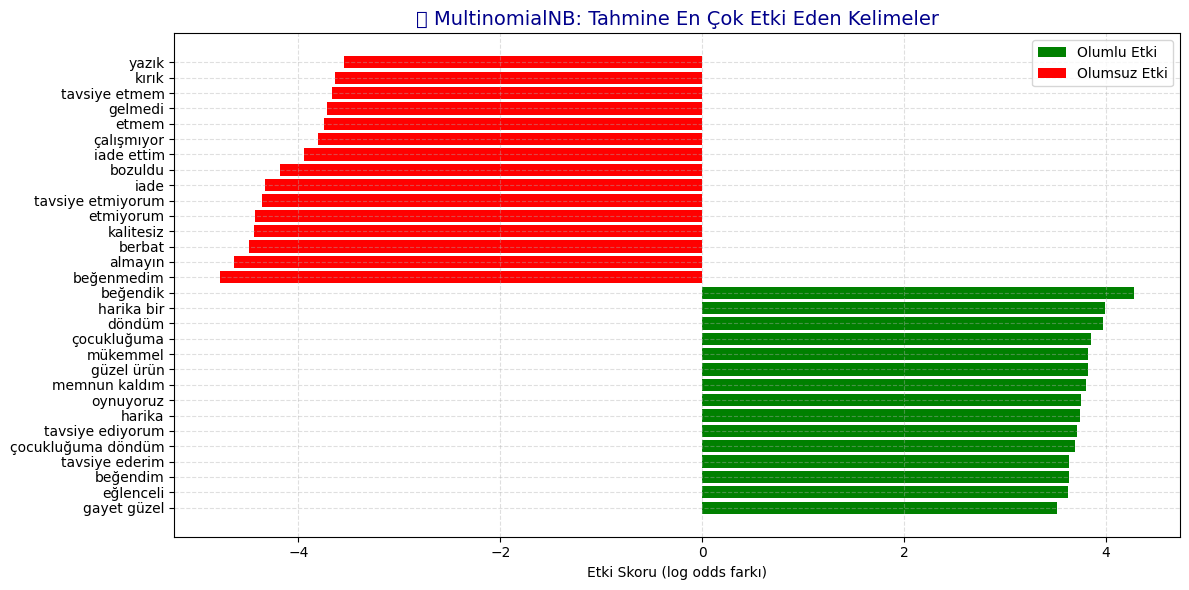

In [17]:
# 🧠 MultinomialNB: Tahmine en çok etki eden kelimelerin görselleştirilmesi

# Log olasılıklar arasındaki farkı hesapla
log_probs = model_nb.feature_log_prob_
importance = log_probs[1] - log_probs[0]

# En olumlu ve en olumsuz etki eden kelimeleri sırala
top_positive_idx = np.argsort(importance)[-15:]
top_negative_idx = np.argsort(importance)[:15]

# Kelime isimlerini al
feature_names = np.array(vectorizer_nb.get_feature_names_out())
top_pos_words = feature_names[top_positive_idx]
top_pos_values = importance[top_positive_idx]
top_neg_words = feature_names[top_negative_idx]
top_neg_values = importance[top_negative_idx]

# Görselleştirme
plt.figure(figsize=(12, 6))
plt.barh(top_pos_words, top_pos_values, color='green', label="Olumlu Etki")
plt.barh(top_neg_words, top_neg_values, color='red', label="Olumsuz Etki")
plt.title("🧠 MultinomialNB: Tahmine En Çok Etki Eden Kelimeler", fontsize=14, color="darkblue")
plt.xlabel("Etki Skoru (log odds farkı)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


C:\Users\yrnck\AppData\Local\Temp\ipykernel_25376\3153610737.py:29: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\yrnck\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


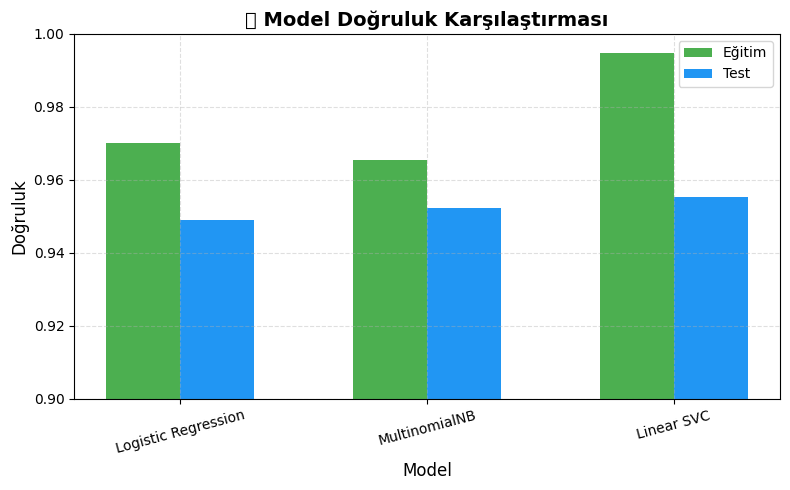

In [18]:
# 📊 Model Doğruluk Karşılaştırması

# Doğruluk değerleri (örnek değerler; kendi çıktılarınıza göre güncelleyebilirsiniz)
model_names = ["Logistic Regression", "MultinomialNB", "Linear SVC"]
egitim_dogruluk = [model.score(X_train_vec, y_train), model_nb.score(X_train_vec_nb, y_train), 0.9948]
test_dogruluk = [model.score(X_test_vec, y_test), model_nb.score(X_test_vec_nb, y_test), 0.9552]

df_karsilastirma = pd.DataFrame({
    "Model": model_names,
    "Eğitim Doğruluğu": egitim_dogruluk,
    "Test Doğruluğu": test_dogruluk
})

# Görselleştirme
plt.figure(figsize=(8, 5))
bar_width = 0.3
index = np.arange(len(df_karsilastirma))

plt.bar(index, df_karsilastirma["Eğitim Doğruluğu"], bar_width, label="Eğitim", color="#4CAF50")
plt.bar(index + bar_width, df_karsilastirma["Test Doğruluğu"], bar_width, label="Test", color="#2196F3")

plt.xlabel("Model", fontsize=12)
plt.ylabel("Doğruluk", fontsize=12)
plt.title("📊 Model Doğruluk Karşılaştırması", fontsize=14, weight="bold")
plt.xticks(index + bar_width / 2, df_karsilastirma["Model"], rotation=15)
plt.ylim(0.90, 1.00)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [19]:
# 📲 Gradio Sekmeli Arayüz: Performans + Etkili Kelimeler + Model Karşılaştırması
import gradio as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 🎯 Model Karşılaştırma Grafiği Fonksiyonu
def model_karsilastirma_grafigi():
    model_names = ["Logistic Regression", "MultinomialNB", "Linear SVC"]
    egitim_dogruluk = [model.score(X_train_vec, y_train), model_nb.score(X_train_vec_nb, y_train), 0.9948]
    test_dogruluk = [model.score(X_test_vec, y_test), model_nb.score(X_test_vec_nb, y_test), 0.9552]

    df = pd.DataFrame({
        "Model": model_names,
        "Eğitim Doğruluğu": egitim_dogruluk,
        "Test Doğruluğu": test_dogruluk
    })

    plt.figure(figsize=(8, 5))
    bar_width = 0.3
    index = np.arange(len(df))

    plt.bar(index, df["Eğitim Doğruluğu"], bar_width, label="Eğitim", color="#4CAF50")
    plt.bar(index + bar_width, df["Test Doğruluğu"], bar_width, label="Test", color="#2196F3")

    plt.xlabel("Model", fontsize=12)
    plt.ylabel("Doğruluk", fontsize=12)
    plt.title("📊 Model Doğruluk Karşılaştırması", fontsize=14, weight="bold")
    plt.xticks(index + bar_width / 2, df["Model"], rotation=15)
    plt.ylim(0.90, 1.00)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()

    path = "model_karsilastirma.png"
    plt.savefig(path)
    plt.close()
    return path

# 🧠 En Etkili Kelimeler Grafiği Fonksiyonu
def etkili_kelimeler_grafigi():
    log_probs = model_nb.feature_log_prob_
    importance = log_probs[1] - log_probs[0]

    top_positive_idx = np.argsort(importance)[-15:]
    top_negative_idx = np.argsort(importance)[:15]

    feature_names = np.array(vectorizer_nb.get_feature_names_out())
    top_pos_words = feature_names[top_positive_idx]
    top_pos_values = importance[top_positive_idx]
    top_neg_words = feature_names[top_negative_idx]
    top_neg_values = importance[top_negative_idx]

    plt.figure(figsize=(12, 6))
    plt.barh(top_pos_words, top_pos_values, color='green', label="Olumlu Etki")
    plt.barh(top_neg_words, top_neg_values, color='red', label="Olumsuz Etki")
    plt.title("🧠 MultinomialNB: En Etkili Kelimeler")
    plt.xlabel("Etki Skoru (log odds farkı)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    path = "etkili_kelimeler.png"
    plt.savefig(path)
    plt.close()
    return path

# 📘 Performans Özeti
def performans_ozeti():
    train_acc = model_nb.score(X_train_vec_nb, y_train)
    test_acc = model_nb.score(X_test_vec_nb, y_test)
    y_probs = model_nb.predict_proba(X_test_vec_nb)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc_val = auc(fpr, tpr)

    return f"""
    <div style='font-size:16px'>
        <b>📘 Eğitim Doğruluğu:</b> %{train_acc*100:.2f}<br>
        <b>📗 Test Doğruluğu:</b> %{test_acc*100:.2f}<br>
        <b>📈 AUC Skoru:</b> {roc_auc_val:.3f}<br><br>
        <i>Model: Multinomial Naive Bayes</i>
    </div>
    """

# 🚀 Arayüz
with gr.Blocks(theme=gr.themes.Soft()) as demo:
    with gr.Tab("📊 Performans"):
        gr.Markdown("### Model Performansı\nEğitim/Test doğruluğu ve AUC skoru")
        performans_output = gr.HTML()
        gr.Button("Performansı Göster").click(fn=performans_ozeti, outputs=performans_output)

    with gr.Tab("📉 Model Karşılaştırması"):
        gr.Markdown("### Modellerin Eğitim ve Test Başarıları (Görsel)")
        grafik_output = gr.Image(label="Model Karşılaştırma Grafiği")
        gr.Button("Grafiği Göster").click(fn=model_karsilastirma_grafigi, outputs=grafik_output)

    with gr.Tab("🧠 En Etkili Kelimeler"):
        gr.Markdown("### MultinomialNB ile Tahmine En Çok Etki Eden Kelimeler")
        kelime_output = gr.Image(label="Etki Skoru ile Kelimeler")
        gr.Button("Kelime Grafiğini Göster").click(fn=etkili_kelimeler_grafigi, outputs=kelime_output)

demo.launch()


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


In [20]:
# 📋 Veri Seti Boyutu ve Sınıf Dağılımı
print(f"Toplam yorum sayısı: {len(df)}")
print(df['Durum'].value_counts(normalize=True).rename("oran (%)") * 100)
print(df['Durum'].value_counts())


Toplam yorum sayısı: 13724
Durum
0    50.757797
1    49.242203
Name: oran (%), dtype: float64
Durum
0    6966
1    6758
Name: count, dtype: int64


In [21]:
# 🧪 Test Seti Üzerindeki Performans (MultinomialNB)
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

y_pred_nb = model_nb.predict(X_test_vec_nb)

print("Doğruluk:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))


Doğruluk: 0.9522768670309654
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      2787
           1       0.94      0.96      0.95      2703

    accuracy                           0.95      5490
   macro avg       0.95      0.95      0.95      5490
weighted avg       0.95      0.95      0.95      5490



C:\Users\yrnck\AppData\Local\Temp\ipykernel_25376\2363689171.py:10: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\yrnck\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


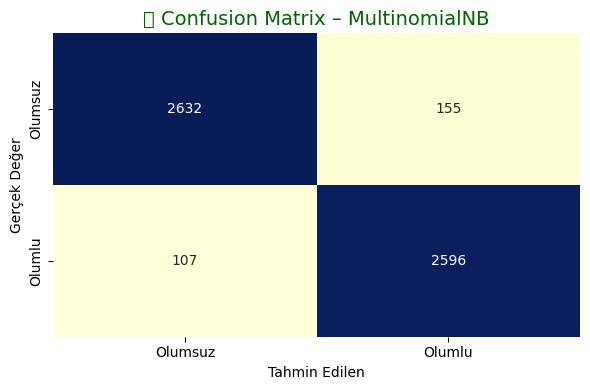

In [22]:
# 🧩 Confusion Matrix – Matplotlib ile
cm = confusion_matrix(y_test, y_pred_nb)
etiketler = ["Olumsuz", "Olumlu"]

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=etiketler, yticklabels=etiketler, cbar=False)
plt.title("🎯 Confusion Matrix – MultinomialNB", fontsize=14, color="darkgreen")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Değer")
plt.tight_layout()
plt.show()


In [23]:
# 📈 AUC Skoru
from sklearn.metrics import roc_auc_score

auc_score = roc_auc_score(y_test, y_probs_nb)
print(f"AUC Skoru: {auc_score:.3f}")


AUC Skoru: 0.989


In [24]:
# 🔁 Cross Validation (CV) ile doğruluk değerlendirme
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model_nb, X_train_vec_nb, y_train, cv=5)
print("CV Doğruluk Skorları:", cv_scores)
print("Ortalama CV Skoru:", np.mean(cv_scores))


CV Doğruluk Skorları: [0.94778385 0.96114147 0.95324833 0.93928355 0.94775213]
Ortalama CV Skoru: 0.9498418642533537


C:\Users\yrnck\AppData\Local\Temp\ipykernel_25376\2039864709.py:33: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\yrnck\AppData\Local\Temp\ipykernel_25376\2039864709.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(path)
C:\Users\yrnck\AppData\Local\Temp\ipykernel_25376\2039864709.py:61: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\yrnck\AppData\Local\Temp\ipykernel_25376\2039864709.py:64: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.savefig(path)
